<a href="https://colab.research.google.com/github/Dhanush-sai-reddy/upondigits/blob/main/Untitled32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jcprogjava/handwritten-digits-dataset-not-in-mnist")

print("Path to dataset files:", path)

100%|██████████| 54.6M/54.6M [00:00<00:00, 136MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jcprogjava/handwritten-digits-dataset-not-in-mnist/versions/4


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

device = torch.device('cuda')

class DigitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []

        dataset_path = os.path.join(root_dir, 'dataset') if not root_dir.endswith('dataset') else root_dir

        for digit in range(10):
            digit_subfolder = os.path.join(dataset_path, str(digit), str(digit))

            if os.path.exists(digit_subfolder):
                files = [f for f in os.listdir(digit_subfolder) if f.lower().endswith('.png')]
                for img_file in files:
                    self.images.append(os.path.join(digit_subfolder, img_file))
                    self.labels.append(digit)
                print(f"Digit {digit}: {len(files)} images")

        print(f"Total: {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('L')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.drop(x)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.drop(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.drop(x)
        x = x.view(-1, 128 * 3 * 3)
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

def train(model, train_loader, val_loader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (pred == labels).sum().item()

        print(f'Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f} Acc={100*correct/total:.2f}% | Val Loss={val_loss/len(val_loader):.4f} Acc={100*val_correct/val_total:.2f}%')

def segment_digits(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = sorted([cv2.boundingRect(c) for c in contours], key=lambda x: x[0])

    digits = []
    for x, y, w, h in boxes:
        if w > 5 and h > 5:
            pad = 5
            digit = gray[max(0,y-pad):min(gray.shape[0],y+h+pad),
                        max(0,x-pad):min(gray.shape[1],x+w+pad)]
            digits.append(digit)
    return digits

def predict_number(model, img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    digit_imgs = segment_digits(img)

    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    model.eval()
    result = []
    for d in digit_imgs:
        d_pil = Image.fromarray(d)
        d_tensor = transform(d_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(d_tensor)
            pred = output.argmax(1).item()
            result.append(pred)

    return int(''.join(map(str, result)))

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = DigitDataset(path, transform=transform)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

model = DigitCNN().to(device)
train(model, train_loader, val_loader, epochs=20)
torch.save(model.state_dict(), 'model.pth')


Digit 0: 10773 images
Digit 1: 10773 images
Digit 2: 10773 images
Digit 3: 10773 images
Digit 4: 10773 images
Digit 5: 10773 images
Digit 6: 10773 images
Digit 7: 10773 images
Digit 8: 10773 images
Digit 9: 10773 images
Total: 107730 images
Epoch 1: Train Loss=2.3047 Acc=9.86% | Val Loss=2.3028 Acc=9.94%
Epoch 2: Train Loss=2.3027 Acc=9.92% | Val Loss=2.3031 Acc=10.20%


KeyboardInterrupt: 

Digit 0: 10773 images
Digit 1: 10773 images
Digit 2: 10773 images
Digit 3: 10773 images
Digit 4: 10773 images
Digit 5: 10773 images
Digit 6: 10773 images
Digit 7: 10773 images
Digit 8: 10773 images
Digit 9: 10773 images
Total: 107730 images

Checking sample images...
Sample 0: label=0, shape=torch.Size([1, 28, 28]), min=0.000, max=1.000, mean=0.092
Sample 1: label=0, shape=torch.Size([1, 28, 28]), min=0.000, max=1.000, mean=0.082
Sample 2: label=0, shape=torch.Size([1, 28, 28]), min=0.000, max=1.000, mean=0.075


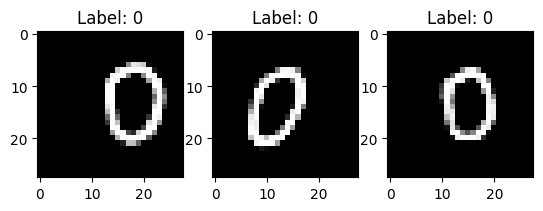

Starting training: 1347 batches per epoch
Epoch 1: Train Loss=0.0813 Acc=97.40% | Val Loss=0.0001 Acc=100.00%
Epoch 2: Train Loss=0.0041 Acc=99.85% | Val Loss=0.0003 Acc=99.99%
Epoch 3: Train Loss=0.0056 Acc=99.83% | Val Loss=0.0011 Acc=99.96%
Epoch 4: Train Loss=0.0050 Acc=99.85% | Val Loss=0.0002 Acc=100.00%
Epoch 5: Train Loss=0.0026 Acc=99.92% | Val Loss=0.0000 Acc=100.00%
Epoch 6: Train Loss=0.0032 Acc=99.92% | Val Loss=0.0000 Acc=100.00%
Epoch 7: Train Loss=0.0023 Acc=99.94% | Val Loss=0.0000 Acc=100.00%
Epoch 8: Train Loss=0.0026 Acc=99.93% | Val Loss=0.0000 Acc=100.00%
Epoch 9: Train Loss=0.0028 Acc=99.93% | Val Loss=0.0000 Acc=100.00%
Epoch 10: Train Loss=0.0010 Acc=99.96% | Val Loss=0.0000 Acc=100.00%
Epoch 11: Train Loss=0.0016 Acc=99.95% | Val Loss=0.0000 Acc=100.00%
Epoch 12: Train Loss=0.0035 Acc=99.92% | Val Loss=0.0000 Acc=100.00%
Epoch 13: Train Loss=0.0005 Acc=99.98% | Val Loss=0.0000 Acc=100.00%
Epoch 14: Train Loss=0.0014 Acc=99.96% | Val Loss=0.0000 Acc=100.00%
Epo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DigitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []

        dataset_path = os.path.join(root_dir, 'dataset') if not root_dir.endswith('dataset') else root_dir

        for digit in range(10):
            digit_subfolder = os.path.join(dataset_path, str(digit), str(digit))

            if os.path.exists(digit_subfolder):
                files = [f for f in os.listdir(digit_subfolder) if f.lower().endswith('.png')]
                for img_file in files:
                    self.images.append(os.path.join(digit_subfolder, img_file))
                    self.labels.append(digit)
                print(f"Digit {digit}: {len(files)} images")

        print(f"Total: {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])

        if img.mode == 'RGBA':
            bg = Image.new('RGB', img.size, (255, 255, 255))
            bg.paste(img, mask=img.split()[3])
            img = bg

        img = img.convert('L')
        img = Image.fromarray(255 - np.array(img))

        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.drop(x)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.drop(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.drop(x)
        x = x.view(-1, 128 * 3 * 3)
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

def train(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Starting training: {len(train_loader)} batches per epoch")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (pred == labels).sum().item()

        print(f'Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f} Acc={100*correct/total:.2f}% | Val Loss={val_loss/len(val_loader):.4f} Acc={100*val_correct/val_total:.2f}%')

def segment_digits(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = sorted([cv2.boundingRect(c) for c in contours], key=lambda x: x[0])

    digits = []
    for x, y, w, h in boxes:
        if w > 5 and h > 5:
            pad = 5
            digit = gray[max(0,y-pad):min(gray.shape[0],y+h+pad),
                        max(0,x-pad):min(gray.shape[1],x+w+pad)]
            digits.append(digit)
    return digits

def predict_number(model, img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    digit_imgs = segment_digits(img)

    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    model.eval()
    result = []
    for d in digit_imgs:
        d_pil = Image.fromarray(d)
        d_tensor = transform(d_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(d_tensor)
            pred = output.argmax(1).item()
            result.append(pred)

    return int(''.join(map(str, result)))

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

dataset = DigitDataset(path, transform=transform)

for i in range(3):
    img, label = dataset[i]
    print(f"Sample {i}: label={label}, shape={img.shape}, min={img.min():.3f}, max={img.max():.3f}, mean={img.mean():.3f}")
    plt.subplot(1, 3, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
plt.show()

train_size = int(0.8 * len(dataset))
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

model = DigitCNN().to(device)
train(model, train_loader, val_loader, epochs=20)
torch.save(model.state_dict(), 'model.pth')

# model.load_state_dict(torch.load('model.pth'))
# number = predict_number(model, 'test_67.png')
# print(number)